In [1]:
import sys
sys.path.append('/usr/local/lib')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.colors as mcol
import matplotlib.cm as cm
import math
import time
import pandas as pd
import json
import pyrealsense2 as rs
import cv2
from scipy import stats
from scipy import ndimage #for finding com
from itertools import cycle
cycol = cycle('bgrcmk') #here I'm generating a list of colors I can plot

In [3]:
# Enabling Advanced Mode

DS5_product_ids = ["0AD1", "0AD2", "0AD3", "0AD4", "0AD5", "0AF6", "0AFE", "0AFF", "0B00", "0B01", "0B03", "0B07"]

def find_device_that_supports_advanced_mode() :
    ctx = rs.context()
    ds5_dev = rs.device()
    devices = ctx.query_devices();
    for dev in devices:
        if dev.supports(rs.camera_info.product_id) and str(dev.get_info(rs.camera_info.product_id)) in DS5_product_ids:
            if dev.supports(rs.camera_info.name):
                print("Found device that supports advanced mode:", dev.get_info(rs.camera_info.name))
            return dev
    raise Exception("No device that supports advanced mode was found")

try:
    dev = find_device_that_supports_advanced_mode()
    advnc_mode = rs.rs400_advanced_mode(dev)
    print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    # Loop until we successfully enable advanced mode
    while not advnc_mode.is_enabled():
        print("Trying to enable advanced mode...")
        advnc_mode.toggle_advanced_mode(True)
        # At this point the device will disconnect and re-connect.
        print("Sleeping for 5 seconds...")
        time.sleep(5)
        # The 'dev' object will become invalid and we need to initialize it again
        dev = find_device_that_supports_advanced_mode()
        advnc_mode = rs.rs400_advanced_mode(dev)
        print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    
except Exception as e:
    print(e)
pass

Found device that supports advanced mode: Intel RealSense D415
Advanced mode is enabled


In [4]:
# Loading presaved parameters 
# If I have another set of parameters I'd like to use already in the json format, I can skip the previous three blocks of code
    
with open("d415paramset_640480.json") as json_data: #Json file to be loaded #NOTE im using default NOT the json that I just created above
    starting_params = json.load(json_data)
    starting_params=str(starting_params).replace("'", '\"') #IF YOU DON't DO THIS IT WILL NOT WORK with the librealsense sdk
    print(starting_params)

{"aux-param-autoexposure-setpoint": "400", "aux-param-colorcorrection1": "0.461914", "aux-param-colorcorrection10": "-0.553711", "aux-param-colorcorrection11": "-0.553711", "aux-param-colorcorrection12": "0.0458984", "aux-param-colorcorrection2": "0.540039", "aux-param-colorcorrection3": "0.540039", "aux-param-colorcorrection4": "0.208008", "aux-param-colorcorrection5": "-0.332031", "aux-param-colorcorrection6": "-0.212891", "aux-param-colorcorrection7": "-0.212891", "aux-param-colorcorrection8": "0.68457", "aux-param-colorcorrection9": "0.930664", "aux-param-depthclampmax": "65536", "aux-param-depthclampmin": "0", "aux-param-disparityshift": "0", "controls-autoexposure-auto": "True", "controls-autoexposure-manual": "33000", "controls-color-autoexposure-auto": "True", "controls-color-autoexposure-manual": "166", "controls-color-backlight-compensation": "0", "controls-color-brightness": "0", "controls-color-contrast": "50", "controls-color-gain": "64", "controls-color-gamma": "300", "co

In [5]:
#Experimental Loop

frame_width=640
frame_height=480
fps=90
number_of_frames_to_record=2500
file = open('pythondepthdata.bin', 'a+b') #open a file for apending binary data
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, frame_width, frame_height, rs.format.z16, fps)
#config.enable_stream(rs.stream.color, frame_width, frame_height, rs.format.bgr8, fps)
advnc_mode.load_json(starting_params) #this is where I start with the Defualt Json
# Start streaming
cfg = pipeline.start(config)
dev = cfg.get_device()
depth_sensor = dev.first_depth_sensor()
#depth_sensor.set_option(rs.option.visual_preset, 2)
hff = rs.hole_filling_filter()    
hff.set_option(rs.option.holes_fill, 1)

iteration = 0;
#preset = 0;
#preset_name = '';
tick=0; #keeping track of the number of loops the experiment has gone through 
background_chunk=500 #I want to use 500 frames for recording the background

In [6]:
start_of_loop=time.time()
with open('pythondepthdata.bin','ab') as binarydata: #While the file called "pythonedpthdata.bin" is open for appending binary, 
    try:
        while tick<number_of_frames_to_record: #aiming for 2000 frames
            tick=tick+1 
            
            # Wait for a coherent pair of frames: depth and color
            frames = pipeline.wait_for_frames()
            depth_frame = frames.get_depth_frame()
            #depth_frame = hff.process(depth_frame); #apply a hole filling filter

            #color_frame = frames.get_color_frame()

            #iteration = iteration + 1
            #if iteration > 100:
               #preset = preset + 1
               #iteration = 0
               #range = depth_sensor.get_option_range(rs.option.visual_preset)
               #preset = preset % range.max
               #depth_sensor.set_option(rs.option.visual_preset, preset)
               #preset_name = depth_sensor.get_option_value_description(rs.option.visual_preset, preset)
        
            # Convert images to numpy arrays
            depth_image = np.asanyarray(depth_frame.get_data())
            #color_image = np.asanyarray(color_frame.get_data())
            depth_image.tofile(binarydata) #save data as binarydata (specified by the with open as line)
            
            if tick==background_chunk:
                output=input("please insert calibration object  ")
        
            # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
            #depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, None, 0.5, 0), cv2.COLORMAP_JET)

            # Stack both images horizontally
            #images = np.hstack((color_image, depth_colormap))
        
            #font = cv2.FONT_HERSHEY_SIMPLEX
            #cv2.putText(images, preset_name,(60,80), font, 4,(255,255,255),2,cv2.LINE_AA) 

            # Show images
            #cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
            #cv2.imshow('RealSense', images)
            #cv2.waitKey(1)
            with open('depth_ts.txt', 'a') as ts:
                ts.write('%s\n' %rs.frame.get_timestamp(frames)) #write time stamp float as a string to a new line

    finally:

        # Stop streaming
        pipeline.stop()
        end_of_loop=time.time() #end timer
        print("Time Elapsed = ", end_of_loop - start_of_loop)
        serialized_string = advnc_mode.serialize_json() #getting the current parameters as a serialized string
        as_json_object = json.loads(serialized_string) #loading the json object from the serialized string
        json_used_in_experiment = str(as_json_object).replace("'", '\"') #converting object into string that can be printed
        print("Final Parameters = ", json_used_in_experiment)

please insert calibration object  180727_5
Time Elapsed =  53.43112301826477
Final Parameters =  {"aux-param-autoexposure-setpoint": "400", "aux-param-colorcorrection1": "0.461914", "aux-param-colorcorrection10": "-0.553711", "aux-param-colorcorrection11": "-0.553711", "aux-param-colorcorrection12": "0.0458984", "aux-param-colorcorrection2": "0.540039", "aux-param-colorcorrection3": "0.540039", "aux-param-colorcorrection4": "0.208008", "aux-param-colorcorrection5": "-0.332031", "aux-param-colorcorrection6": "-0.212891", "aux-param-colorcorrection7": "-0.212891", "aux-param-colorcorrection8": "0.68457", "aux-param-colorcorrection9": "0.930664", "aux-param-depthclampmax": "65536", "aux-param-depthclampmin": "0", "aux-param-disparityshift": "0", "controls-autoexposure-auto": "True", "controls-autoexposure-manual": "33000", "controls-color-autoexposure-auto": "True", "controls-color-autoexposure-manual": "166", "controls-color-backlight-compensation": "0", "controls-color-brightness": "0",

In [7]:
#delete all variables
#for name in dir():
#    if not name.startswith('_'):
#        del globals()[name]

In [8]:
#frame_width=640
#frame_height=480
#fps=90
#background_chunk=500

In [9]:
#redo the imports
#import matplotlib.pyplot as plt
#import numpy as np
#import random
#import matplotlib.colors as mcol
#import matplotlib.cm as cm
#import math
#import time
#import pandas as pd
#import json
#import pyrealsense2 as rs
#import cv2
#from scipy import stats
#from scipy import ndimage
#from itertools import cycle
#cycol = cycle('bgrcmk') #here I'm generating a list of colors I can plot

In [10]:
rawframes = np.fromfile('pythondepthdata.bin', dtype=np.uint16) #A highly efficient way of reading binary data with a known data-type, as well as parsing simply formatted text files. Data written using the tofile method can be read using this function.
frames = rawframes.reshape(-1, frame_height, frame_width) #.reshape simply restructures data into dimensions of your choosing. -1 means find the number of segments that structures the data into the dimnesions shown afterwards

In [11]:
!rm pythondepthdata.bin 
!rm depth_ts.txt 
#rm -r d415_Movie/
#rm -r dlc_Movie/

In [12]:
del rawframes

In [13]:
number_of_frames,video_height,video_width=frames.shape[0],frames.shape[1],frames.shape[2];
#set number of frames equal to the first element in reshaped.shape
#set video height to the second element in reshaped.shape
#set video width to the third element in reshaped.shape
print('The shape of the video is {0} by {1} and it has {2} frames'.format(video_height,video_width,number_of_frames))
#note that the nubmers below are one greater than the actual indices that exist
#there is no reshaped[number_of_frames,height,width], the last frame is reshaped[number_of_frames-1,height-1,width-1]

The shape of the video is 480 by 640 and it has 2500 frames


In [14]:
!mkdir dlc_Movie
!mkdir d415_Movie

In [15]:
current_frame=background_chunk
dpi=80
box_size=192 #this is how big I want my video to be (200 by 200) #YOU WILL GET ERRORS IF YOU'RE BOX IS BIGGER THAN THE MIDDLE OF THE IMAGE (x or y)

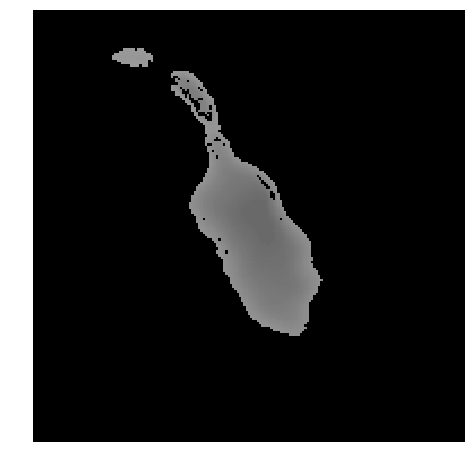

In [16]:
current_frame=background_chunk
picked_frame=current_frame
frame_of_interest=frames[picked_frame] 
#know your background (I happen to know background is between frame 5250 and 5350)
backgroundmean=np.median(frames[0:background_chunk], axis=0) #may be better to use median
backgroundvariance=np.var(frames[0:background_chunk], axis=0)
#if the difference between the background and the frame is greater than expected, it's probably our object! 
#note that I arbitrarily pick 5 stdeviations away, it's worth knowing if the noise is actually gaussian
backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (7*np.sqrt(backgroundvariance)) #if its 5 standard its NOISE
#we expect positive values for high differences. make them stay by multiplying by 1
backgroundmultiplier[backgroundmultiplier>0]=1
#we expect negative values or no change for small differences. probably just noise, get rid of them by multiplying by 0
backgroundmultiplier[backgroundmultiplier<=0]=0
#apply our expectations to the matrix
frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest,backgroundmultiplier)


#I can plot the background subtracted image
winningrow=0
winningcountr=video_width
for rowpixels in range(0,video_height):
    currentcountr=np.count_nonzero(frame_of_interest_backgroundsubtracted[rowpixels,:]==0)
    if currentcountr<winningcountr:
        winningcountr=currentcountr
        winningrow=rowpixels
 
winningcolumn=0
winningcountc=video_height
for columnpixels in range(0,video_width):
    currentcountc=np.count_nonzero(frame_of_interest_backgroundsubtracted[:,columnpixels]==0)
    if currentcountc<winningcountc:
        winningcountc=currentcountc
        winningcolumn=columnpixels

if winningrow<(box_size/2):
    winningrow=(int(box_size/2))
if winningrow>(video_height-box_size/2):
    winningrow=int(video_height-box_size/2-1)
if winningcolumn<(box_size/2):
     winningcolumn=(int(box_size/2))
if winningcolumn>(video_width-box_size/2):
    winningcolumn=int(video_width-box_size/2-1)


figsize = video_width / float(dpi), video_height / float(dpi)
fig=plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')


plt.imshow(frame_of_interest_backgroundsubtracted[winningrow-int(box_size/2):winningrow+int(box_size/2-1),winningcolumn-int(box_size/2):winningcolumn+int(box_size/2-1)],cmap=plt.get_cmap('gray'))
object_median=np.median(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted>0])
plt.clim(object_median-90,object_median+90)
#plt.imshow(frame_of_interest_backgroundsubtracted[32:231,200:300])
#plt.clim(object_median-200,object_median+200

In [17]:
#Making a movie for Deep Lab Cut
current_frame=background_chunk
for f in range(int(number_of_frames-background_chunk)):

    #Now let's try to put this all together but in another random frame
    #pick a frame
    picked_frame=current_frame
    frame_of_interest=frames[picked_frame] 
    #know your background (I happen to know background is between frame 5250 and 5350)
    backgroundmean=np.mean(frames[0:background_chunk], axis=0) #may be better to use median
    backgroundvariance=np.var(frames[0:background_chunk], axis=0)
    #if the difference between the background and the frame is greater than expected, it's probably our object! 
    #note that I arbitrarily pick 5 stdeviations away, it's worth knowing if the noise is actually gaussian
    backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (9*np.sqrt(backgroundvariance)) #if its 5 standard its NOISE
    #we expect positive values for high differences. make them stay by multiplying by 1
    backgroundmultiplier[backgroundmultiplier>0]=1
    #we expect negative values or no change for small differences. probably just noise, get rid of them by multiplying by 0
    backgroundmultiplier[backgroundmultiplier<=0]=0
    #apply our expectations to the matrix
    frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest,backgroundmultiplier)
    
    #################################################################
    #HOW I CAN FIND THE CENTER OF THE OBJECT TO CROP THE PLOT
    
    winningrow=0
    winningcountr=video_width
    for rowpixels in range(0,video_height):
        currentcountr=np.count_nonzero(frame_of_interest_backgroundsubtracted[rowpixels,:]==0)
        if currentcountr<winningcountr:
            winningcountr=currentcountr
            winningrow=rowpixels
 
    winningcolumn=0
    winningcountc=video_height
    for columnpixels in range(0,video_width):
        currentcountc=np.count_nonzero(frame_of_interest_backgroundsubtracted[:,columnpixels]==0)
        if currentcountc<winningcountc:
            winningcountc=currentcountc
            winningcolumn=columnpixels

    if winningrow<(box_size/2):
        winningrow=(int(box_size/2))
    if winningrow>(video_height-box_size/2):
        winningrow=int(video_height-box_size/2-1)
    if winningcolumn<(box_size/2):
         winningcolumn=(int(box_size/2))
    if winningcolumn>(video_width-box_size/2):
        winningcolumn=int(video_width-box_size/2-1)
    
    print(f)
    #####################################################################
    ## FUCK WHITE SPACES
    
    figsize = video_width / float(dpi), video_height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
            
    plt.imshow(frame_of_interest_backgroundsubtracted[winningrow-int(box_size/2):winningrow+int(box_size/2-1),winningcolumn-int(box_size/2):winningcolumn+int(box_size/2-1)],cmap=plt.get_cmap('gray'))
    plt.clim(object_median-80,object_median+80)

    ##
    
    fig.savefig('/home/rockwell/Real_Sensible_Moseq/data_acquisition/dlc_Movie/dlc_frame_%06d.png'%f, bbox_inches='tight') #the bbox_inches kwarg removes the white space from the plot
    plt.close()
    current_frame=current_frame+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [18]:
"""


#Making Non cropped video
current_frame=background_chunk

for f in range(int(number_of_frames-background_chunk)):

    #Now let's try to put this all together but in another random frame
    #pick a frame
    picked_frame=current_frame
    frame_of_interest=frames[picked_frame] 
    #know your background (I happen to know background is between frame 5250 and 5350)
    backgroundmean=np.mean(frames[0:background_chunk], axis=0) #may be better to use median
    backgroundvariance=np.var(frames[0:background_chunk], axis=0)
    #if the difference between the background and the frame is greater than expected, it's probably our object! 
    #note that I arbitrarily pick 5 stdeviations away, it's worth knowing if the noise is actually gaussian
    backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (9*np.sqrt(backgroundvariance)) #if its 5 standard its NOISE
    #we expect positive values for high differences. make them stay by multiplying by 1
    backgroundmultiplier[backgroundmultiplier>0]=1
    #we expect negative values or no change for small differences. probably just noise, get rid of them by multiplying by 0
    backgroundmultiplier[backgroundmultiplier<=0]=0
    #apply our expectations to the matrix
    frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest,backgroundmultiplier)
    
    #################################################################
    
    
    print(f)
    
    figsize = video_width / float(dpi), video_height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    plt.imshow(frame_of_interest_backgroundsubtracted[0:video_height,0:video_width])
    plt.clim(object_median-80,object_median+80)

    ##
    
    fig.savefig('/home/rockwell/Real_Sensible_Moseq/data_acquisition/d415_Movie/d415_frame_%06d.png'%f, bbox_inches='tight') #the bbox_inches kwarg removes the white space from the plot
    plt.close()
    current_frame=current_frame+1
    
    
    
    """

"\n\n\n#Making Non cropped video\ncurrent_frame=background_chunk\n\nfor f in range(int(number_of_frames-background_chunk)):\n\n    #Now let's try to put this all together but in another random frame\n    #pick a frame\n    picked_frame=current_frame\n    frame_of_interest=frames[picked_frame] \n    #know your background (I happen to know background is between frame 5250 and 5350)\n    backgroundmean=np.mean(frames[0:background_chunk], axis=0) #may be better to use median\n    backgroundvariance=np.var(frames[0:background_chunk], axis=0)\n    #if the difference between the background and the frame is greater than expected, it's probably our object! \n    #note that I arbitrarily pick 5 stdeviations away, it's worth knowing if the noise is actually gaussian\n    backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (9*np.sqrt(backgroundvariance)) #if its 5 standard its NOISE\n    #we expect positive values for high differences. make them stay by multiplying by 1\n    backgrou

In [19]:
#background subtracted Movie as an MP4! Perfect data input for leap
!ffmpeg -i /home/rockwell/Real_Sensible_Moseq/data_acquisition/dlc_Movie/dlc_frame_%06d.png -c:v libx264 -vf fps=90 -pix_fmt yuv420p -r 90 dlc_out.mp4

ffmpeg version 4.0.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.2 (GCC) 20140120 (Red Hat 4.8.2-15)
  configuration: --prefix=/home/rockwell/miniconda3 --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-cxxflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-lpthread -lm -lz' --enable-zlib --enable-pic --enable-pthreads --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --enable-libfreetype --enable-gnutls --enable-libx264
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, image2, from '/home/rockwell/Real_Sensible_Moseq/data_acquisition/

In [20]:
"""


#Save entire window. Perfect for showing friends!
!ffmpeg -i /home/rockwell/Real_Sensible_Moseq/data_acquisition/d415_Movie/d415_frame_%06d.png -c:v libx264 -vf fps=90 -pix_fmt yuv420p -r 90 d415_out.mp4



"""

'\n\n\n#Save entire window. Perfect for showing friends!\n!ffmpeg -i /home/rockwell/Real_Sensible_Moseq/data_acquisition/d415_Movie/d415_frame_%06d.png -c:v libx264 -vf fps=90 -pix_fmt yuv420p -r 90 d415_out.mp4\n\n\n\n'

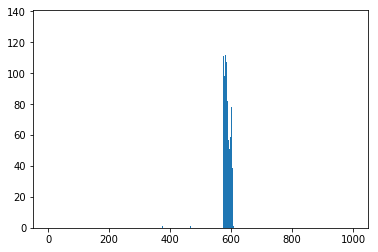

In [24]:
plt.hist(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0],bins=range(1,1000))
plt.show()